
# **DA 623 Course Project: Image Classification using CNN**

# **Introduction:**

# This part of project aims to classify images of Santa Claus using two different deep learning models: Convolutional Neural Network (CNN) and Deep Neural Network (DNN). The dataset used is the "Is That Santa?" dataset, which contains images of Santa Claus and other objects.

# **Dataset:**

# The dataset is downloaded from KaggleHub and consists of two folders: "train" and "test". The "train" folder contains images for training the models, while the "test" folder is used for evaluating the performance of the trained models.


INSTALLING DEPENDENCIES

In [ ]:
!pip install kagglehub

import kagglehub
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
import os
from glob import glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
!pip install torchviz  # Installing required library
from torchviz import make_dot
from IPython.display import Image, display
import torch.nn as nn
from torch.utils.data import DataLoader
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

A LOOK AT DATASET

# **Load and explore the dataset:**

# 1. Download the dataset using `kagglehub.dataset_download`.
# 2. Define the device (CPU or GPU) for training.
# 3. Apply transformations to the images using `transforms.Compose`. These transformations include resizing, flipping, rotation, color adjustments, and normalization.
# 4. Create `ImageFolder` instances for the train and test datasets.
# 5. Display a few sample images from the dataset using `show_images` function.

Path to dataset files: /kaggle/input/is-that-santa-image-classification
614
616
Train Images:


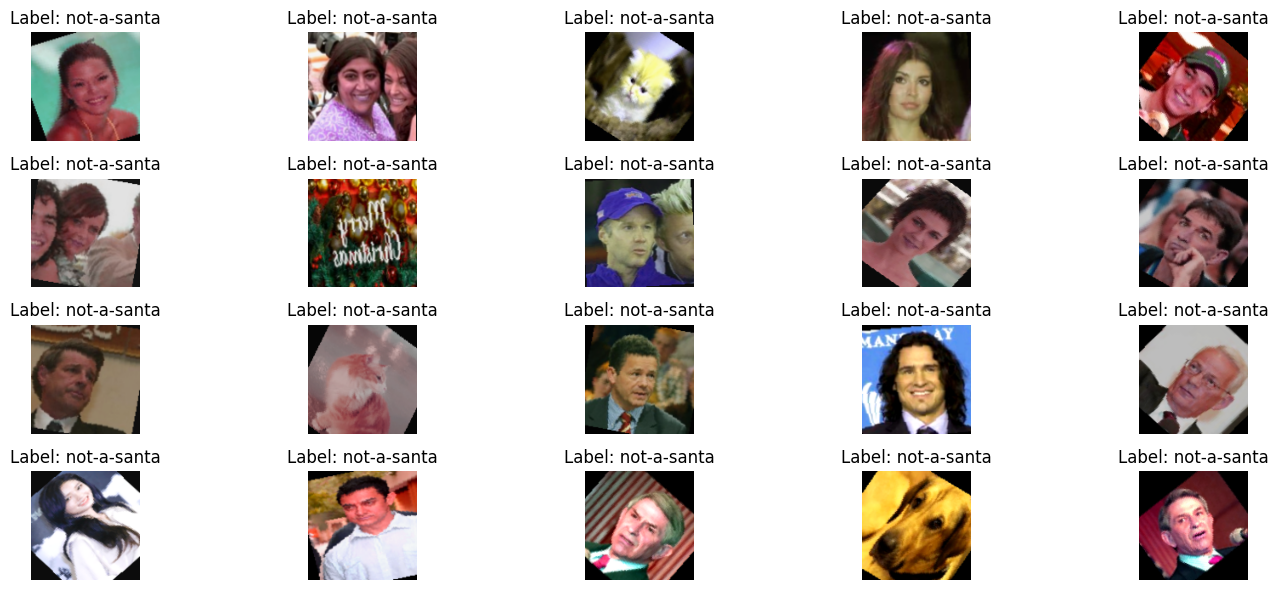

Test Images:


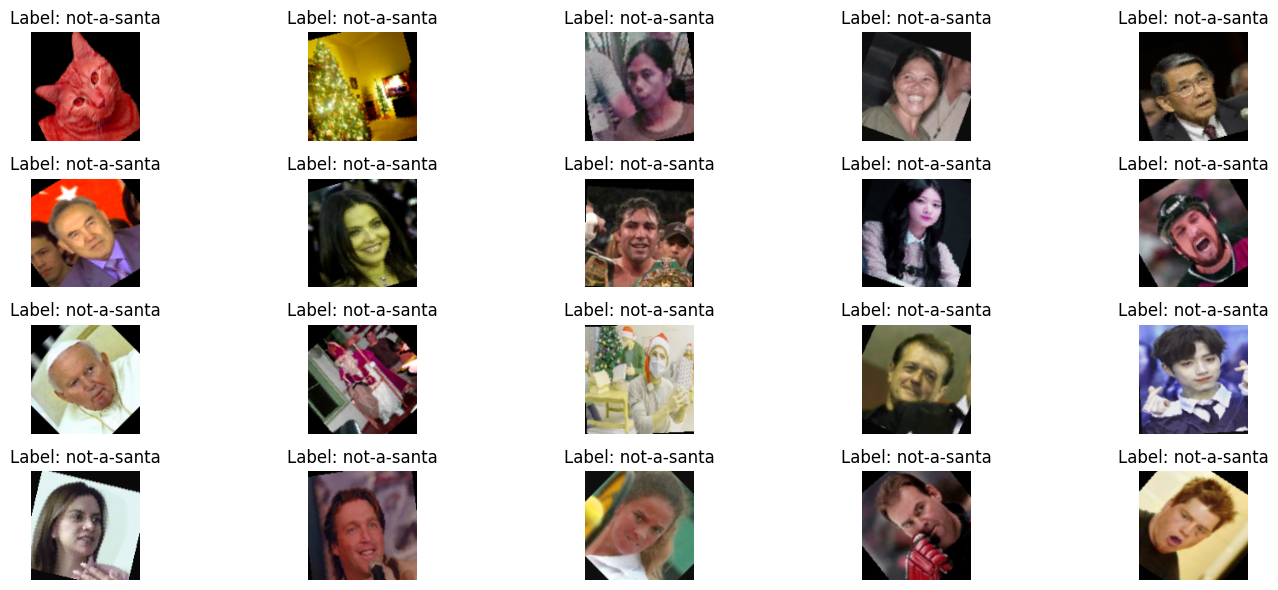

{'not-a-santa': 0, 'santa': 1}

In [ ]:
#LOAD DATASET
path = kagglehub.dataset_download("deepcontractor/is-that-santa-image-classification")

print("Path to dataset files:", path)

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.7),  # Increase flip probability
    transforms.RandomRotation(degrees=45),  # Increase rotation range
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Add color jitter
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)),  # Add random resized crop
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train = ImageFolder(os.path.join(path, "is that santa/train") , transform = tfm)
test = ImageFolder(os.path.join(path, "is that santa/test") , transform = tfm)

len_train = len(train)
len_test = len(test)

print(len_train)
print(len_test)


def show_images(dataset, num_images=20):
    """Displays a specified number of images from a dataset."""
    fig, axes = plt.subplots(num_images // 5, 5, figsize=(15, 6))  # Adjusted for 20 images
    axes = axes.flatten()
    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # Reshape for display
        img = (img + 1) / 2  # Denormalize
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {dataset.classes[label]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

print("Train Images:")
show_images(train)
print("Test Images:")
show_images(test)
#Mapping the index
train.class_to_idx

# **CNN Architecture:**

# 1. Define the CNN architecture using the `santa` class. It consists of convolutional layers, batch normalization, max pooling, activation functions, dropout, and fully connected layers.
# 2. Create an instance of the `santa` class.
# 3. Visualize the CNN architecture using `make_dot` and display it.


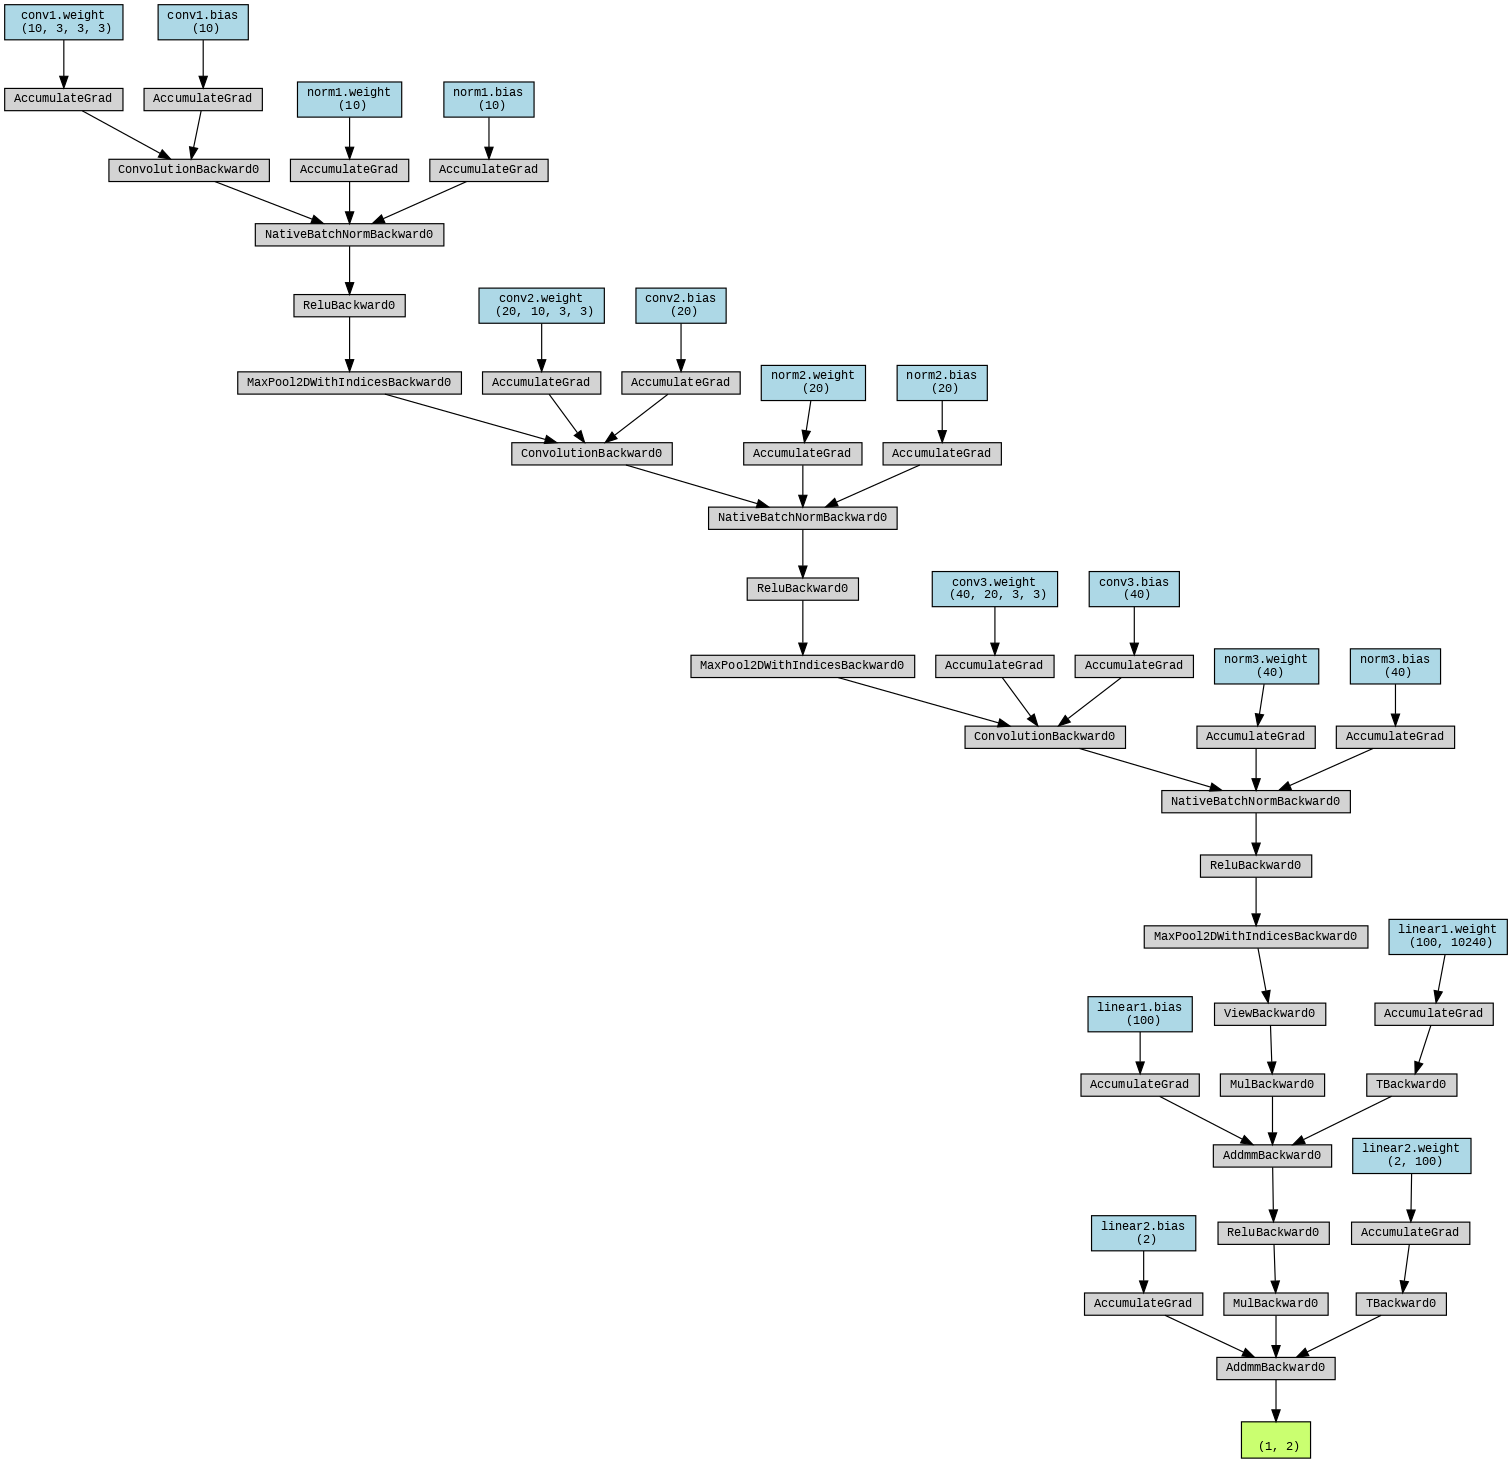

In [ ]:
train_loader = DataLoader(train,
                          batch_size = 100,
                          drop_last = False,
                          shuffle = True)

test_loader = DataLoader(test,
                        batch_size = 100,
                        drop_last = False,
                        shuffle = False)

class santa(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3,10,kernel_size = 3, stride=1,padding=1)
        self.norm1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10,20,kernel_size = 3,stride = 1,padding = 1)
        self.norm2 = nn.BatchNorm2d(20)
        self.conv3 = nn.Conv2d(20,40,kernel_size = 3,stride = 1,padding = 1)
        self.norm3 = nn.BatchNorm2d(40)
        self.pool = nn.MaxPool2d(2, 2)
        self.act_fn = nn.ReLU()

        self.linear1 = nn.Linear(40*16*16, 100)
        self.linear2 = nn.Linear(100, num_classes)
        self.drop = nn.Dropout(p=0.4)

    def forward(self, x):
        x = self.pool(F.relu(self.norm1(self.conv1(x))))
        x = self.pool(F.relu(self.norm2(self.conv2(x))))
        x = self.pool(F.relu(self.norm3(self.conv3(x))))
        x = x.view(-1, 40*16*16)
        x = self.drop(x)
        x = F.relu(self.linear1(x))
        x = self.drop(x)
        x = self.linear2(x)

        return x

model = santa()
model

dummy_input = torch.randn(1, 3, 128, 128, device=DEVICE)
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))
dot.format = "png"  # Set format explicitly
dot.engine = "dot"  # Use dot engine for layering
dot.rankdir = "LR"  # Set direction to Left-to-Right
dot.render("cnn_architecture")  # Save as PNG image

display(Image(filename='cnn_architecture.png'))

# **DNN Architecture and Training:**

# 1. Define the DNN architecture using the `santaDNN` class. It consists of fully connected layers, dropout, and an output layer.
# 2. Create an instance of the `santaDNN` class.
# 3. Define the loss function and optimizer for the DNN model.
# 4. Train the DNN model for a specified number of epochs and track the training and testing losses.
# 5. Plot the training and testing losses for the DNN model.

In [ ]:
class santaDNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 64)
        self.drop3 = nn.Dropout(0.3)

        self.out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))a
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.relu(self.fc3(x))
        x = self.drop3(x)
        return self.out(x)


# Flatten the input for DNN
train_loader_dnn = DataLoader(train, batch_size=100, shuffle=True)
test_loader_dnn = DataLoader(test, batch_size=100, shuffle=False)

input_size = 3 * 128 * 128  # Assuming input images are 128x128
# hidden_size = 128 # This variable was not being used inside the class definition,
num_classes = 2

# removed hidden_size as argument
model_dnn = santaDNN(input_size, num_classes).to(DEVICE)

# **Visualizing Activations:**

# 1. Define a function `visualize_activation` to display the activations of different layers in the models.
# 2. Register hooks to capture the activations of specific layers.
# 3. Visualize the activations of the convolutional layers in the CNN model and the first fully connected layer in the DNN model.

In [ ]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks for your 'is that santa' CNN model
# Changed 'model_cnn' to 'model' to match the CNN model variable name
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv3.register_forward_hook(get_activation('conv3'))

# Register hook for your 'is that santa' DNN model
model_dnn.fc1.register_forward_hook(get_activation('fc1'))

# === Visualization Function (Modified) ===
def visualize_activation(layer_name, num_channels=6):
    act = activations[layer_name].squeeze()
    if act.dim() == 4:  # For CNN (adjust dim if necessary)
        fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))
        for idx in range(num_channels):
            axes[idx].imshow(act[0, idx].cpu(), cmap='viridis') # Assuming batch size is first dimension
            axes[idx].axis('off')
        plt.suptitle(f'Activations of {layer_name}')
        plt.show()
    elif act.dim() == 2:  # For DNN (adjust dim if necessary)
        plt.figure(figsize=(10, 5))
        plt.plot(act[0].cpu().numpy()) # Assuming batch size is first dimension
        plt.title(f'Activations of {layer_name}')
        plt.xlabel('Neuron Index')
        plt.ylabel('Activation')
        plt.show()

# **Training the CNN Model:**

# 1. Define the loss function (`CrossEntropyLoss`) and optimizer (`Adam`).
# 2. Define the training function (`train_fn`) and testing function (`test_fn`).
# 3. Train the model for a specified number of epochs and track the training and testing losses.
# 4. Implement early stopping to prevent overfitting.
# 5. Plot the training and testing losses.

===== Epoch 1 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 0 - Train Loss 0.6942 - test Loss 0.6890

===== Epoch 2 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1 - Train Loss 0.4962 - test Loss 0.7455

===== Epoch 3 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2 - Train Loss 0.4230 - test Loss 0.8424

===== Epoch 4 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3 - Train Loss 0.4066 - test Loss 0.7122

===== Epoch 5 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4 - Train Loss 0.4080 - test Loss 0.6367

===== Epoch 6 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5 - Train Loss 0.3264 - test Loss 0.3993

===== Epoch 7 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6 - Train Loss 0.3279 - test Loss 0.3694

===== Epoch 8 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7 - Train Loss 0.4033 - test Loss 0.3063

===== Epoch 9 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8 - Train Loss 0.3125 - test Loss 0.3162

===== Epoch 10 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9 - Train Loss 0.2829 - test Loss 0.2857

===== Epoch 11 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10 - Train Loss 0.2700 - test Loss 0.2879

===== Epoch 12 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11 - Train Loss 0.2522 - test Loss 0.2504

===== Epoch 13 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12 - Train Loss 0.2775 - test Loss 0.2864

===== Epoch 14 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13 - Train Loss 0.2915 - test Loss 0.2749

===== Epoch 15 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14 - Train Loss 0.2586 - test Loss 0.2947

===== Epoch 16 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15 - Train Loss 0.2897 - test Loss 0.2765

===== Epoch 17 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16 - Train Loss 0.2384 - test Loss 0.2791

===== Epoch 18 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17 - Train Loss 0.2715 - test Loss 0.2514

===== Epoch 19 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18 - Train Loss 0.2188 - test Loss 0.2634

===== Epoch 20 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19 - Train Loss 0.2145 - test Loss 0.2589

===== Epoch 21 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20 - Train Loss 0.2388 - test Loss 0.2775

===== Epoch 22 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21 - Train Loss 0.2260 - test Loss 0.2554

===== Epoch 23 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22 - Train Loss 0.2284 - test Loss 0.2395

===== Epoch 24 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23 - Train Loss 0.2196 - test Loss 0.2493

===== Epoch 25 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24 - Train Loss 0.2332 - test Loss 0.2548

===== Epoch 26 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25 - Train Loss 0.2324 - test Loss 0.2468

===== Epoch 27 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 26 - Train Loss 0.2308 - test Loss 0.2401

===== Epoch 28 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 27 - Train Loss 0.2122 - test Loss 0.2681

===== Epoch 29 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 28 - Train Loss 0.2144 - test Loss 0.2485

===== Epoch 30 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 29 - Train Loss 0.2065 - test Loss 0.2346

===== Epoch 31 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 30 - Train Loss 0.2056 - test Loss 0.2378

===== Epoch 32 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 31 - Train Loss 0.2147 - test Loss 0.2573

===== Epoch 33 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 32 - Train Loss 0.2005 - test Loss 0.2194

===== Epoch 34 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 33 - Train Loss 0.2191 - test Loss 0.2300

===== Epoch 35 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 34 - Train Loss 0.2026 - test Loss 0.2427

===== Epoch 36 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 35 - Train Loss 0.2261 - test Loss 0.2432

===== Epoch 37 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 36 - Train Loss 0.2017 - test Loss 0.2649

===== Epoch 38 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 37 - Train Loss 0.1820 - test Loss 0.2310

===== Epoch 39 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 38 - Train Loss 0.1907 - test Loss 0.2787

===== Epoch 40 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 39 - Train Loss 0.2222 - test Loss 0.2328

===== Epoch 41 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 40 - Train Loss 0.2026 - test Loss 0.2380

===== Epoch 42 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 41 - Train Loss 0.2055 - test Loss 0.2929

===== Epoch 43 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 42 - Train Loss 0.2351 - test Loss 0.2500

===== Epoch 44 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 43 - Train Loss 0.2117 - test Loss 0.2831

===== Epoch 45 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 44 - Train Loss 0.2044 - test Loss 0.2457

===== Epoch 46 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 45 - Train Loss 0.2167 - test Loss 0.2543

===== Epoch 47 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 46 - Train Loss 0.2308 - test Loss 0.2346

===== Epoch 48 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 47 - Train Loss 0.1915 - test Loss 0.2572

===== Epoch 49 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 48 - Train Loss 0.2001 - test Loss 0.2274

===== Epoch 50 =====


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 49 - Train Loss 0.2024 - test Loss 0.2417



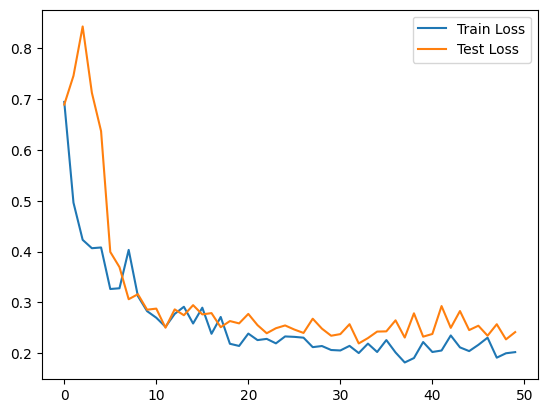

  0%|          | 0/7 [00:00<?, ?it/s]

0.8993506493506493

In [ ]:
model.to(DEVICE)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)
EPOCHS = 50

def train_fn(train_loader, model, loss_func, optimizer):
    losses = []
    model.train()

    progress = tqdm(train_loader, total=len(train_loader))
    for i,(imgs, labels) in enumerate(progress):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        y_preds = model(imgs)
        loss = loss_func(y_preds, labels) #loss function created

        optimizer.zero_grad()         # Clearing all previous gradients, setting to zero
        loss.backward()               # Back Propagation
        optimizer.step()              # Updating the parameters

        losses.append(loss.item())

    return np.mean(losses)

def test_fn(test_loader,model,loss_func,optimizer):
    losses = []
    model.eval()

    progress = tqdm(test_loader, total=len(test_loader))
    for i,(imgs, labels) in enumerate(progress):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            y_pred = model(imgs)
            loss = loss_func(y_pred,labels)

        losses.append(loss.item())


    return np.mean(losses)

train_losses = []
test_losses = []

best_dict = None
best_loss = np.inf

start_time_cnn = time.time()
for ep in range(EPOCHS):
    print('='*5 + f" Epoch {ep+1} " + '='*5)

    tr_loss = train_fn(train_loader, model, loss_func, optimizer)
    ts_loss = test_fn(test_loader, model, loss_func, optimizer)

    # EARLY STOPPING
    if ts_loss < best_loss:
        best_loss = ts_loss
        best_dict = model.state_dict()

    train_losses.append(tr_loss)
    test_losses.append(ts_loss)

    print(f"Epoch {ep} - Train Loss {tr_loss:.4f} - test Loss {ts_loss:.4f}\n")

end_time_cnn = time.time()
cnn_runtime = end_time_cnn - start_time_cnn

plt.plot(train_losses,label='Train Loss')

plt.plot(test_losses,label='Test Loss')

plt.legend()
plt.show()
model.load_state_dict(best_dict)

test_preds = []
test_trues = []

progress = tqdm(test_loader, total=len(test_loader))
model.eval()

for i, (imgs, labels) in enumerate(progress):
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        y_preds = model(imgs)

    pred_labels = np.argmax(y_preds.cpu().detach().numpy(), axis=1)
    test_preds.extend(pred_labels.tolist())
    test_trues.extend(labels.cpu().detach().numpy().tolist())

metrics.accuracy_score(test_preds, test_trues)

Epoch [1/50], Train Loss: 0.9758, Test Loss: 0.7500
Epoch [2/50], Train Loss: 0.7300, Test Loss: 0.6650
Epoch [3/50], Train Loss: 0.6973, Test Loss: 0.5856
Epoch [4/50], Train Loss: 0.6448, Test Loss: 0.6158
Epoch [5/50], Train Loss: 0.6356, Test Loss: 0.5581
Epoch [6/50], Train Loss: 0.6151, Test Loss: 0.6023
Epoch [7/50], Train Loss: 0.5574, Test Loss: 0.5836
Epoch [8/50], Train Loss: 0.5575, Test Loss: 0.5440
Epoch [9/50], Train Loss: 0.5651, Test Loss: 0.5564
Epoch [10/50], Train Loss: 0.5124, Test Loss: 0.5307
Epoch [11/50], Train Loss: 0.5177, Test Loss: 0.5419
Epoch [12/50], Train Loss: 0.5700, Test Loss: 0.5254
Epoch [13/50], Train Loss: 0.5248, Test Loss: 0.5427
Epoch [14/50], Train Loss: 0.5159, Test Loss: 0.5287
Epoch [15/50], Train Loss: 0.5071, Test Loss: 0.5083
Epoch [16/50], Train Loss: 0.4989, Test Loss: 0.4978
Epoch [17/50], Train Loss: 0.4895, Test Loss: 0.5114
Epoch [18/50], Train Loss: 0.5294, Test Loss: 0.5111
Epoch [19/50], Train Loss: 0.4392, Test Loss: 0.5061
Ep

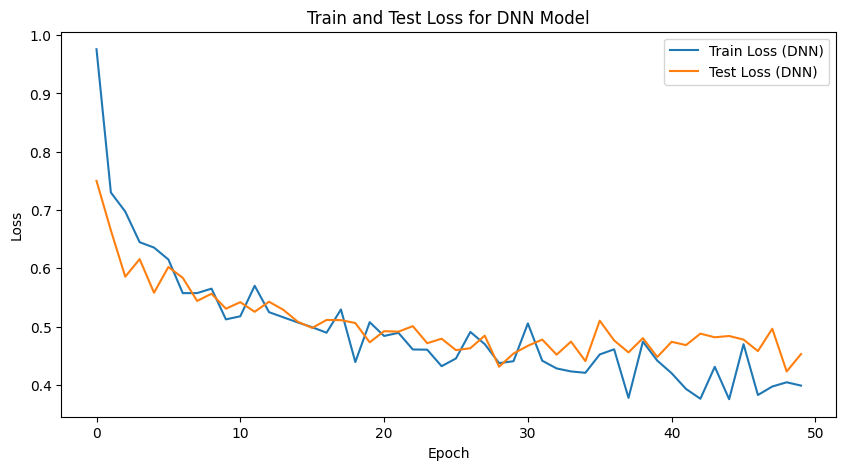

In [ ]:


# TRAINING DNN MODEL
loss_func_dnn = nn.CrossEntropyLoss()
optimizer_dnn = torch.optim.Adam(model_dnn.parameters(), lr=0.001)
EPOCHS_DNN = 50

train_losses_dnn = []
test_losses_dnn = []
start_time_dnn = time.time()

for epoch in range(EPOCHS_DNN):
    running_loss_train = 0.0
    model_dnn.train()
    for i, data in enumerate(train_loader_dnn, 0):
        inputs, labels = data
        inputs = inputs.view(-1, input_size).to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer_dnn.zero_grad()
        outputs = model_dnn(inputs)
        loss = loss_func_dnn(outputs, labels)
        loss.backward()
        optimizer_dnn.step()

        running_loss_train += loss.item()

    train_loss_epoch = running_loss_train / len(train_loader_dnn)
    train_losses_dnn.append(train_loss_epoch)

    running_loss_test = 0.0
    model_dnn.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, data in enumerate(test_loader_dnn, 0):
            inputs, labels = data
            inputs = inputs.view(-1, input_size).to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model_dnn(inputs)
            loss = loss_func_dnn(outputs, labels)
            running_loss_test += loss.item()

    test_loss_epoch = running_loss_test / len(test_loader_dnn)
    test_losses_dnn.append(test_loss_epoch)

    print(f'Epoch [{epoch+1}/{EPOCHS_DNN}], Train Loss: {train_loss_epoch:.4f}, Test Loss: {test_loss_epoch:.4f}')


end_time_dnn = time.time()
dnn_runtime = end_time_dnn - start_time_dnn
plt.figure(figsize=(10, 5))
plt.plot(train_losses_dnn, label='Train Loss (DNN)')
plt.plot(test_losses_dnn, label='Test Loss (DNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss for DNN Model')
plt.legend()
plt.show()


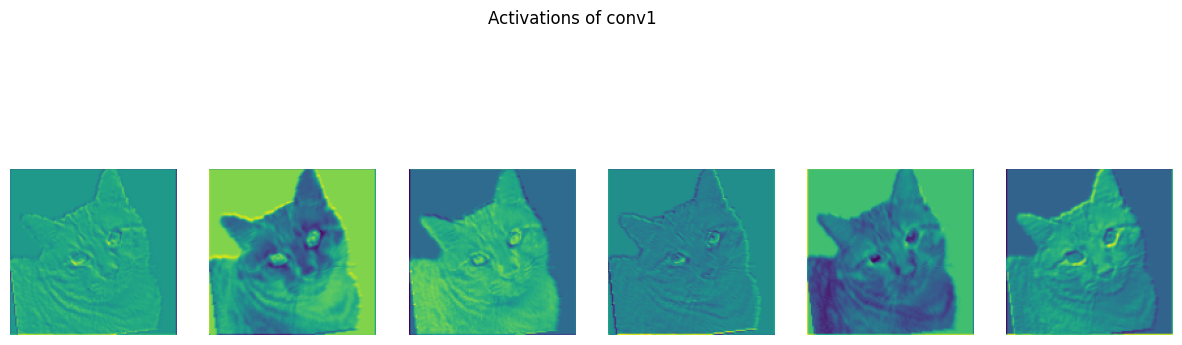

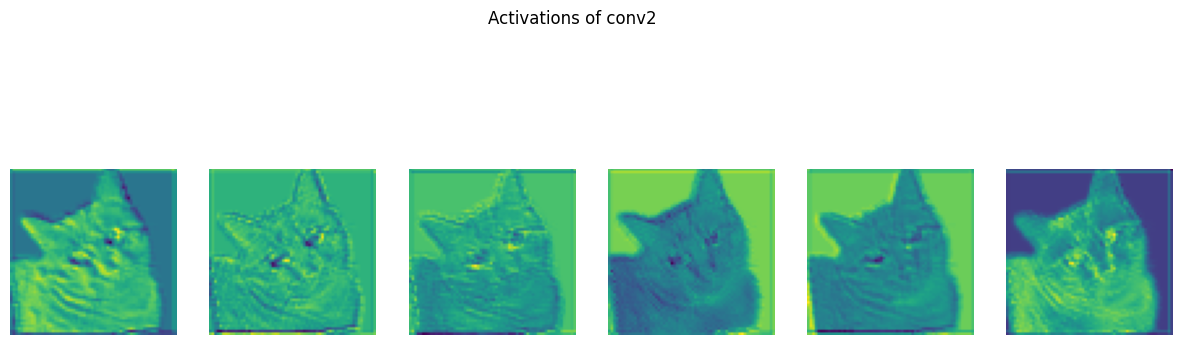

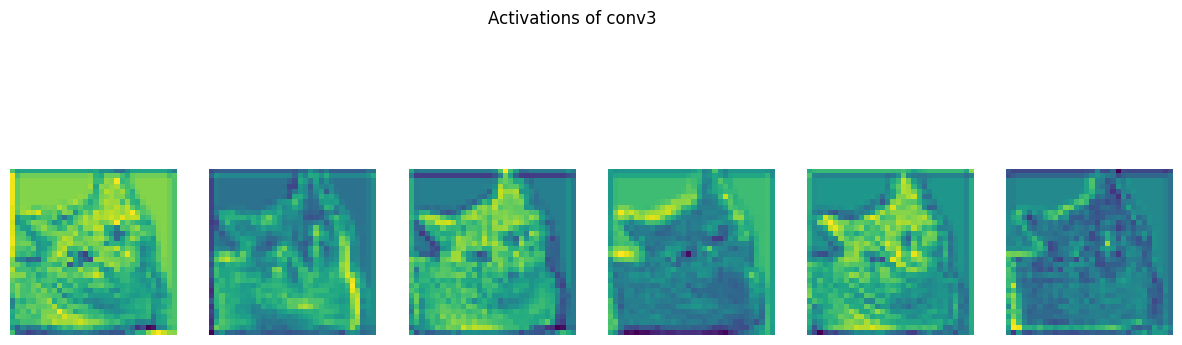

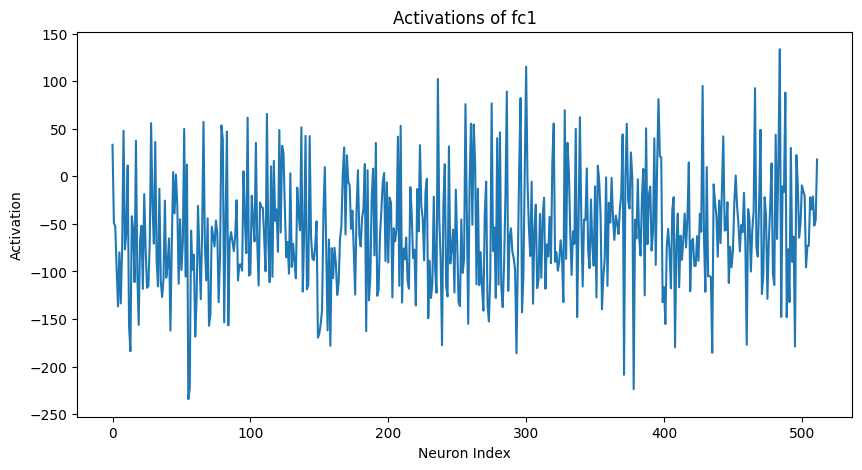

In [ ]:
# === Visualization Call (After Training) ===
# Get a sample image from your 'is that santa' dataset
sample_img, _ = next(iter(test_loader))
sample_img = sample_img.to(DEVICE)

# Run a forward pass and visualize activations for CNN
model.eval()  # Changed model_cnn to model
with torch.no_grad():
    _ = model(sample_img)  # Changed model_cnn to model

visualize_activation('conv1')
visualize_activation('conv2')
visualize_activation('conv3')

# Run a forward pass and visualize activations for DNN
model_dnn.eval()
with torch.no_grad():
    _ = model_dnn(sample_img.view(sample_img.size(0), -1))  # Flatten input for DNN

visualize_activation('fc1')

# **Model Evaluation and Comparison:**

# 1. Evaluate the CNN and DNN models on the test set and calculate accuracy, precision, recall, and F1-score.
# 2. Create confusion matrices for both models to visualize their performance.
# 3. Present a summary table comparing the performance metrics and runtime of the two models.


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

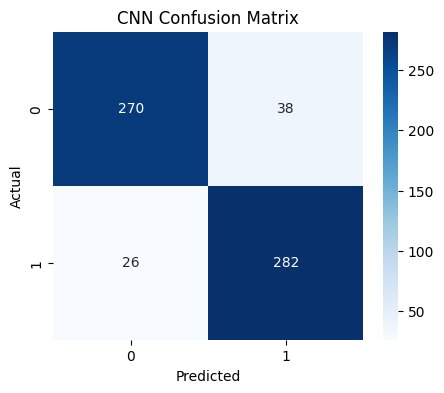

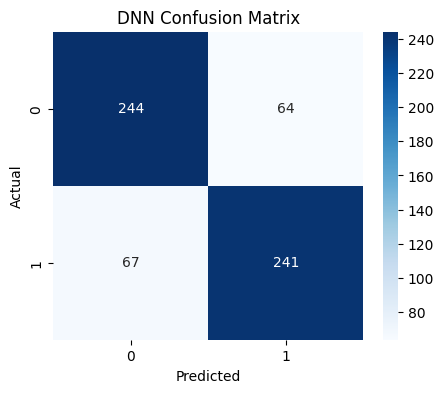


==== Summary Comparison ====
Metric          | CNN        | DNN       
----------------------------------------
Accuracy        | 0.8961     | 0.7873    
Precision       | 0.8812     | 0.7902    
Recall          | 0.9156     | 0.7825    
F1-Score        | 0.8981     | 0.7863    
Runtime (s)     | 1533.1219  | 1211.2385 
Parameters      | 1033782    | 25314242  


In [ ]:


# Evaluate CNN model
test_preds_cnn = []
test_trues_cnn = []

progress = tqdm(test_loader, total=len(test_loader))
model.eval()  # Set the CNN model to evaluation mode

for i, (imgs, labels) in enumerate(progress):
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.no_grad():
        y_preds = model(imgs)

    pred_labels = np.argmax(y_preds.cpu().detach().numpy(), axis=1)
    test_preds_cnn.extend(pred_labels.tolist())
    test_trues_cnn.extend(labels.cpu().detach().numpy().tolist())

# Evaluate DNN model
test_preds_dnn = []
test_trues_dnn = []

progress = tqdm(test_loader_dnn, total=len(test_loader_dnn))
model_dnn.eval()  # Set the DNN model to evaluation mode

for i, (imgs, labels) in enumerate(progress):
    imgs = imgs.view(-1, input_size).to(DEVICE)  # Flatten input for DNN
    labels = labels.to(DEVICE)

    with torch.no_grad():
        y_preds = model_dnn(imgs)

    pred_labels = np.argmax(y_preds.cpu().detach().numpy(), axis=1)
    test_preds_dnn.extend(pred_labels.tolist())
    test_trues_dnn.extend(labels.cpu().detach().numpy().tolist())



# Confusion Matrix
cm_cnn = confusion_matrix(test_trues_cnn, test_preds_cnn)
cm_dnn = confusion_matrix(test_trues_dnn, test_preds_dnn)




def plot_conf_matrix(cm, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_conf_matrix(cm_cnn, "CNN Confusion Matrix")
plot_conf_matrix(cm_dnn, "DNN Confusion Matrix")

# Calculate metrics for CNN
accuracy_cnn = accuracy_score(test_trues_cnn, test_preds_cnn)
precision_cnn = precision_score(test_trues_cnn, test_preds_cnn)
recall_cnn = recall_score(test_trues_cnn, test_preds_cnn)
f1_cnn = f1_score(test_trues_cnn, test_preds_cnn)

# Calculate metrics for DNN
accuracy_dnn = accuracy_score(test_trues_dnn, test_preds_dnn)
precision_dnn = precision_score(test_trues_dnn, test_preds_dnn)
recall_dnn = recall_score(test_trues_dnn, test_preds_dnn)
f1_dnn = f1_score(test_trues_dnn, test_preds_dnn)




summary = {
    "Accuracy": [accuracy_score(test_trues_cnn, test_preds_cnn), accuracy_score(test_trues_dnn, test_preds_dnn)],
    "Precision": [precision_score(test_trues_cnn, test_preds_cnn), precision_score(test_trues_dnn, test_preds_dnn)],
    "Recall": [recall_score(test_trues_cnn, test_preds_cnn), recall_score(test_trues_dnn, test_preds_dnn)],
    "F1-Score": [f1_score(test_trues_cnn, test_preds_cnn), f1_score(test_trues_dnn, test_preds_dnn)],
    "Runtime (s)": [cnn_runtime, dnn_runtime],
    "Parameters": [
        sum(p.numel() for p in model.parameters()), # Changed model_cnn to model
        sum(p.numel() for p in model_dnn.parameters())
    ]
}

# Display summary table
print("\n==== Summary Comparison ====")
print(f"{'Metric':<15} | {'CNN':<10} | {'DNN':<10}")
print("-" * 40)
for key, val in summary.items():
    print(f"{key:<15} | {val[0]:<10.4f} | {val[1]:<10.4f}" if isinstance(val[0], float) else f"{key:<15} | {val[0]:<10} | {val[1]:<10}")